# Github Repository Data Exploration  

## Setup 

Ensure you are in the `coding-smart-github` conda environment and have the following packages in your environment:
```bash

```

### Github Authentication 

Create a classic access token via [Github Authentication Settings](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/creating-a-personal-access-token#creating-a-personal-access-token-classic) and create a file called `config.cfg` with the following content: 
```bash
[ACCESS]
token = <your-access-token>
```
Ensure you've pasted in your token, but leave `[ACCESS]` and `token = `.

### imports

In [1]:
import pandas as pd
pd.set_option('max_colwidth', 1000)

import numpy as np

import os

import configparser

import requests

from github import Github

import datetime

from tqdm import tqdm

import matplotlib.pyplot as plt  

import json

import string

### github access

In [54]:
# set up github access token with github package: 

config = configparser.ConfigParser()
config.read('../config.cfg')
config.sections()

access_token = config['ACCESS']['token']
g = Github(access_token) 


In [55]:
help(Github())

Help on Github in module github.MainClass object:

class Github(builtins.object)
 |  Github(login_or_token=None, password=None, jwt=None, base_url='https://api.github.com', timeout=15, user_agent='PyGithub/Python', per_page=30, verify=True, retry=None, pool_size=None)
 |  
 |  This is the main class you instantiate to access the Github API v3. Optional parameters allow different authentication methods.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, login_or_token=None, password=None, jwt=None, base_url='https://api.github.com', timeout=15, user_agent='PyGithub/Python', per_page=30, verify=True, retry=None, pool_size=None)
 |      :param login_or_token: string
 |      :param password: string
 |      :param base_url: string
 |      :param timeout: integer
 |      :param user_agent: string
 |      :param per_page: int
 |      :param verify: boolean or string
 |      :param retry: int or urllib3.util.retry.Retry object
 |      :param pool_size: int
 |  
 |  create_from_raw_data(sel

In [3]:
# PARSE GITHUB REPO URL INTO USERNAME AND REPO NAME

 # via @karacolada 
def parse_github_repo_url(url):  
    """ Take github URL and split into username or organisation ('username') and repo name ('repo_name'). 
    Return username and repo name. 
    URL must start with 'https://' to split correctly.
    
    Examples: 
    >>> parse_github_repo_url("https://github.com/riboviz/riboviz")
    ('riboviz', 'riboviz')

    >>> parse_github_repo_url("https://github.com/FlicAnderson/20230215-JournalClub-BestPractices")
    ('FlicAnderson', '20230215-JournalClub-BestPractices')
    """
    assert isinstance(url, str), 'Ensure input url is a string' 
    
    try:
        _,_,_,username,repo_name = url.split('/')
    except ValueError:
        print(f"Could not unpack URL {url} into 5 segments. Confirm input is correct (and starts 'https://github.com/') or refactor function parse_github_repo_url.")
    
    return username, repo_name

In [4]:
parse_github_repo_url("https://github.com/riboviz/riboviz")
#parse_github_repo_url("https://github.com/FlicAnderson/20230215-JournalClub-BestPractices")  # extra example
#parse_github_repo_url(123)  # this correctly triggers assertion error.

('riboviz', 'riboviz')

In [5]:
# GET REPO JSON DATA 

def get_repo_json(username, repo_name):
    
    """ Gets json data for a github repository when given a valid username and repository name. 
    Returns 'json_repo_content', a dict. 
        
    Examples: 
    
    >>> get_repo_json('FlicAnderson', '20230215-JournalClub-BestPractices')
    {'id': 595202904,
     'node_id': 'R_kgDOI3oTWA',
     'name': '20230215-JournalClub-BestPractices',
     'full_name': 'FlicAnderson/20230215-JournalClub-BestPractices',
     'private': False,
     'owner': {'login 
     ... lots more content...
    
    # To list all fields load 'json' module and use keys(), e.g. 
    >>> content = get_repo_json('riboviz', 'riboviz')
    >>> content.keys()
    >>> ... list of fields returned for the dict. 
    
    # To access the value for a given key, save output to a variable and index the key name: 
    >>> content = get_repo_json('FlicAnderson', '20230215-JournalClub-BestPractices')
    >>> content['has_issues'] 
    True
    """
    assert isinstance(username, str), 'Ensure input username is a string' 
    assert isinstance(repo_name, str), 'Ensure input repo_name is a string' 
        
    json_repo_content = requests.get(f'https://api.github.com/repos/{username}/{repo_name}').json() 
                
    return json_repo_content

In [6]:
get_repo_json('riboviz', 'riboviz')

{'id': 184749972,
 'node_id': 'MDEwOlJlcG9zaXRvcnkxODQ3NDk5NzI=',
 'name': 'riboviz',
 'full_name': 'riboviz/riboviz',
 'private': False,
 'owner': {'login': 'riboviz',
  'id': 50236323,
  'node_id': 'MDEyOk9yZ2FuaXphdGlvbjUwMjM2MzIz',
  'avatar_url': 'https://avatars.githubusercontent.com/u/50236323?v=4',
  'gravatar_id': '',
  'url': 'https://api.github.com/users/riboviz',
  'html_url': 'https://github.com/riboviz',
  'followers_url': 'https://api.github.com/users/riboviz/followers',
  'following_url': 'https://api.github.com/users/riboviz/following{/other_user}',
  'gists_url': 'https://api.github.com/users/riboviz/gists{/gist_id}',
  'starred_url': 'https://api.github.com/users/riboviz/starred{/owner}{/repo}',
  'subscriptions_url': 'https://api.github.com/users/riboviz/subscriptions',
  'organizations_url': 'https://api.github.com/users/riboviz/orgs',
  'repos_url': 'https://api.github.com/users/riboviz/repos',
  'events_url': 'https://api.github.com/users/riboviz/events{/privacy}

In [7]:
content = get_repo_json('riboviz', 'riboviz')
#content['open_issues'] # check how many open issues  

In [8]:
# REPO CONNECTION FUNCTION 
# set up access token separately (see above!)

def get_repo_connection(username, repo_name): 
     """Create connection to github repository and get details 
     when given 'username' and 'repo_name' repository name. 
     repo_connection is type: github.Repository.Repository.  
     
     NOTE: Requires access_token setup with Github package. 
     
     Examples: 
     >>> get_repo_connection('riboviz', 'riboviz')
     Repository(full_name="riboviz/riboviz")
     
     """
     #g = Github(access_token)  # this access token setup line is required, plus extra setup code elsewhere above. 

     assert isinstance(username, str), 'Ensure input username is a string'  
     assert isinstance(repo_name, str), 'Ensure input repo_name is a string'  
    
     repo_connection = g.get_repo(f'{username}/{repo_name}')
    
     return repo_connection

In [9]:
get_repo_connection('riboviz', 'riboviz')

Repository(full_name="riboviz/riboviz")

In [10]:
repo_con = get_repo_connection('riboviz', 'riboviz')
type(repo_con)

github.Repository.Repository

In [11]:
iss = repo_con.get_issues() 
iss[0]

Issue(title="Updated riboviz documentation", number=481)

In [12]:
iss = repo_con.get_issues() 
iss[0].raw_data  # get the json content

{'url': 'https://api.github.com/repos/riboviz/riboviz/issues/481',
 'repository_url': 'https://api.github.com/repos/riboviz/riboviz',
 'labels_url': 'https://api.github.com/repos/riboviz/riboviz/issues/481/labels{/name}',
 'comments_url': 'https://api.github.com/repos/riboviz/riboviz/issues/481/comments',
 'events_url': 'https://api.github.com/repos/riboviz/riboviz/issues/481/events',
 'html_url': 'https://github.com/riboviz/riboviz/pull/481',
 'id': 1649028927,
 'node_id': 'PR_kwDOCwMPlM5NVbwM',
 'number': 481,
 'title': 'Updated riboviz documentation',
 'user': {'login': 'HannahMaroof',
  'id': 123739479,
  'node_id': 'U_kgDOB2AdVw',
  'avatar_url': 'https://avatars.githubusercontent.com/u/123739479?v=4',
  'gravatar_id': '',
  'url': 'https://api.github.com/users/HannahMaroof',
  'html_url': 'https://github.com/HannahMaroof',
  'followers_url': 'https://api.github.com/users/HannahMaroof/followers',
  'following_url': 'https://api.github.com/users/HannahMaroof/following{/other_user}'

In [13]:
iss = repo_con.get_issues() 
iss[0]._rawData # gives the json issue content 


{'url': 'https://api.github.com/repos/riboviz/riboviz/issues/481',
 'repository_url': 'https://api.github.com/repos/riboviz/riboviz',
 'labels_url': 'https://api.github.com/repos/riboviz/riboviz/issues/481/labels{/name}',
 'comments_url': 'https://api.github.com/repos/riboviz/riboviz/issues/481/comments',
 'events_url': 'https://api.github.com/repos/riboviz/riboviz/issues/481/events',
 'html_url': 'https://github.com/riboviz/riboviz/pull/481',
 'id': 1649028927,
 'node_id': 'PR_kwDOCwMPlM5NVbwM',
 'number': 481,
 'title': 'Updated riboviz documentation',
 'user': {'login': 'HannahMaroof',
  'id': 123739479,
  'node_id': 'U_kgDOB2AdVw',
  'avatar_url': 'https://avatars.githubusercontent.com/u/123739479?v=4',
  'gravatar_id': '',
  'url': 'https://api.github.com/users/HannahMaroof',
  'html_url': 'https://github.com/HannahMaroof',
  'followers_url': 'https://api.github.com/users/HannahMaroof/followers',
  'following_url': 'https://api.github.com/users/HannahMaroof/following{/other_user}'

### per_page argument working: 

In [71]:
# in requests package: get function:  
  # requests.get(url, params={key: value}, args)  
    # e.g. requests.get(url, timeout=2.50)
  # via https://www.w3schools.com/python/ref_requests_get.asp  

username = "riboviz"  
repo_name = "riboviz"

#print(requests.get(url = f'https://api.github.com/repos/{username}/{repo_name}/issues', params = {'per_page':5}))
# gives: 
#<Response [200]>

a = requests.get(url = f'https://api.github.com/repos/{username}/{repo_name}/issues', params = {'per_page':5}).json()
print(pd.DataFrame(a))
# per_page working here to reduce output to 5 issues  

                                                       url  \
0  https://api.github.com/repos/riboviz/riboviz/issues/481   
1  https://api.github.com/repos/riboviz/riboviz/issues/478   
2  https://api.github.com/repos/riboviz/riboviz/issues/476   
3  https://api.github.com/repos/riboviz/riboviz/issues/475   
4  https://api.github.com/repos/riboviz/riboviz/issues/474   

                                 repository_url  \
0  https://api.github.com/repos/riboviz/riboviz   
1  https://api.github.com/repos/riboviz/riboviz   
2  https://api.github.com/repos/riboviz/riboviz   
3  https://api.github.com/repos/riboviz/riboviz   
4  https://api.github.com/repos/riboviz/riboviz   

                                                              labels_url  \
0  https://api.github.com/repos/riboviz/riboviz/issues/481/labels{/name}   
1  https://api.github.com/repos/riboviz/riboviz/issues/478/labels{/name}   
2  https://api.github.com/repos/riboviz/riboviz/issues/476/labels{/name}   
3  https://api.g

In [97]:
a = requests.get(url = f'https://api.github.com/repos/{username}/{repo_name}/issues', params = {'per_page':5}).json()
print(json.dumps(a, indent=4, separators=(". ", " = "))) # slightly easier to read json printing with json.dumps()

[
    {
        "url" = "https://api.github.com/repos/riboviz/riboviz/issues/481". 
        "repository_url" = "https://api.github.com/repos/riboviz/riboviz". 
        "labels_url" = "https://api.github.com/repos/riboviz/riboviz/issues/481/labels{/name}". 
        "comments_url" = "https://api.github.com/repos/riboviz/riboviz/issues/481/comments". 
        "events_url" = "https://api.github.com/repos/riboviz/riboviz/issues/481/events". 
        "html_url" = "https://github.com/riboviz/riboviz/pull/481". 
        "id" = 1649028927. 
        "node_id" = "PR_kwDOCwMPlM5NVbwM". 
        "number" = 481. 
        "title" = "Updated riboviz documentation". 
        "user" = {
            "login" = "HannahMaroof". 
            "id" = 123739479. 
            "node_id" = "U_kgDOB2AdVw". 
            "avatar_url" = "https://avatars.githubusercontent.com/u/123739479?v=4". 
            "gravatar_id" = "". 
            "url" = "https://api.github.com/users/HannahMaroof". 
            "html_url" = "h

In [111]:
a = requests.get(url = f'https://api.github.com/repos/{username}/{repo_name}/issues', params = {'per_page':5}).json()
a[0]
a[0].get('title')

'Updated riboviz documentation'

### use repo url from list of repo urls

In [142]:
repo_list = ["https://github.com/riboviz/riboviz/", "https://github.com/FlicAnderson/20230215-JournalClub-BestPractices"]

for repo_i in repo_list: 
    print(repo_i)

https://github.com/riboviz/riboviz/
https://github.com/FlicAnderson/20230215-JournalClub-BestPractices


In [161]:
# check the string.rstrip() logic

repo_list = ["test", "test/", "test/test", "test/test/", "test/test//", "https://github.com/test/test", "https://github.com/test/test/"]

for item in repo_list:
    clean_item = item.rstrip("/")
    print(clean_item)

test
test
test/test
test/test
test/test
https://github.com/test/test
https://github.com/test/test


In [158]:
# uses string.split() and string.rstrip()

repo_list = ["https://github.com/riboviz/riboviz", "https://github.com/FlicAnderson/20230215-JournalClub-BestPractices"]

## pygithub.get_repo() does NOT handle input with trailing slash (e.g. "riboviz/riboviz/") 
# to get the break, run following loop with THIS input vvv
#repo_list = ["https://github.com/riboviz/riboviz/", "https://github.com/FlicAnderson/20230215-JournalClub-BestPractices"]

for repo_i in repo_list: 
    repo_name = (repo_i.split("https://github.com/"))[1]
    repo_name_clean = (repo_name.rstrip("/"))
    #repo = g.get_repo(repo_name)
    print(repo_name)
    print(g.get_repo(repo_name_clean))  
    
    # OK. THIS WORKS. 
    # THIS LOOP WILL PULL REPO URL FROM LIST, CLEAN IT, AND OPEN A REPO CONNECTION FOR IT. 
    

riboviz/riboviz
Repository(full_name="riboviz/riboviz")
FlicAnderson/20230215-JournalClub-BestPractices
Repository(full_name="FlicAnderson/20230215-JournalClub-BestPractices")


### repo_name_clean(repo_url) function:

In [204]:
def repo_name_clean (repo_url): 
    """Remove trailing slashes and github url root from string repo names.
    :param repo_url: repository names in url format or as 'username/repo_name' format.
    :type str:
    :returns: `repo_name` string without github url root or trailing slashes.  
    :type str:
    
    Examples: 
    ----------  
    
    >>> repo_name_clean("https://github.com/riboviz/riboviz")
    'riboviz/riboviz' 
    
    >>> repo_name_clean("https://github.com/FlicAnderson/20230215-JournalClub-BestPractices/")
    'FlicAnderson/20230215-JournalClub-BestPractices'
    
    """

    if isinstance(repo_url, list): 
            
        assert isinstance(repo_url, str), 'Ensure input url is a string. If list of repos, use list comprension e.g. `[repo_name_clean(x) for x in repo_list]`.' 
   
    
    if isinstance(repo_url, str): 
        
        assert "," not in repo_url, 'Input contains commas - ensure input is string of ONE repo only.'
        assert ";" not in repo_url, 'Input contains semicolons - ensure input is string of ONE repo only.'
                
        try:
            repo_url = (repo_url.split("https://github.com/"))[1]
            repo_name = (repo_url.rstrip("/"))
        
        except ValueError:
            print(f"Could not clean repo_url into username/repo_name format. Confirm input is correct (and if url is given that it starts 'https://github.com/').")
        
        return repo_name
    

In [205]:
repo_name_clean("https://github.com/riboviz/riboviz")

'riboviz/riboviz'

In [206]:
repo_name_clean("https://github.com/FlicAnderson/20230215-JournalClub-BestPractices/")

'FlicAnderson/20230215-JournalClub-BestPractices'

In [207]:
repo_list = ["https://github.com/riboviz/riboviz/", "https://github.com/FlicAnderson/20230215-JournalClub-BestPractices"]

In [208]:
repo_name_clean(repo_list)

AssertionError: Ensure input url is a string. If list of repos, use list comprension e.g. `[repo_name_clean(x) for x in repo_list]`.

In [190]:
help(repo_name_clean)

Help on function repo_name_clean in module __main__:

repo_name_clean(repo_url)
    Remove trailing slashes and github url root from string repo names.
    :param repo_url: repository names in url format or as 'username/repo_name' format.
    :type str:
    :returns: `repo_name` string without github url root or trailing slashes.  
    :type str:
    
    Examples: 
    ----------  
    
    >>> repo_name_clean()



In [209]:
repo_name_clean("https://github.com/riboviz/riboviz/, https://github.com/FlicAnderson/20230215-JournalClub-BestPractices")

AssertionError: Could not clean input. It contains commas - ensure input is string of ONE repo only.

True

In [174]:
type(repo_list)

list

In [172]:
len(repo_list)

2

In [175]:
type(repo_list[0])

str

In [177]:
[repo_name_clean(x) for x in repo_list] # list comprehension! 

['riboviz/riboviz', 'FlicAnderson/20230215-JournalClub-BestPractices']

### pagination 

In [80]:
a = requests.get(url = f'https://api.github.com/repos/{username}/{repo_name}/issues', params = {'per_page':5}).links
#dir(a)
print(a)

{'next': {'url': 'https://api.github.com/repositories/184749972/issues?per_page=5&page=2', 'rel': 'next'}, 'last': {'url': 'https://api.github.com/repositories/184749972/issues?per_page=5&page=33', 'rel': 'last'}}


Using link headers
When a response is paginated, the response headers will include a link header. The link header will be omitted if the endpoint does not support pagination or if all results fit on a single page. The link header contains URLs that you can used to fetch additional pages of results. To see the response headers if you are using curl or GitHub CLI, pass the `--include` flag with your request. To see the response headers if you are using a library to make requests, follow the documentation for that library. For example:

```bash
curl --include --request GET \
--url "https://api.github.com/repos/octocat/Spoon-Knife/issues" \
--header "Accept: application/vnd.github+json"
```

If the response is paginated, the link header will look something like this:
```bash
link: <https://api.github.com/repositories/1300192/issues?page=2>; rel="prev", <https://api.github.com/repositories/1300192/issues?page=4>; rel="next", <https://api.github.com/repositories/1300192/issues?page=515>; rel="last", <https://api.github.com/repositories/1300192/issues?page=1>; rel="first"
```

The link header provides the URL for the previous, next, first, and last page of results:

The link header provides the URL for the previous, next, first, and last page of results:

The URL for the previous page is followed by `rel="prev"`.  
The URL for the next page is followed by `rel="next"`.  
The URL for the last page is followed by `rel="last"`.  
The URL for the first page is followed by `rel="first"`.  

In some cases, only a subset of these links are available. For example, the link to the previous page won't be included if you are on the first page of results, and the link to the last page won't be included if it can't be calculated.

You can use the URLs from the link header to request another page of results. For example, to request the last page of results based on the previous example:

### Get json issue data with requests.get(...).json()

In [64]:
# GET  REPO ISSUES DATA 

def get_json_repo_issues(username, repo_name):
    
    """ Gets LIST of json format issues data for a github repository when given a valid username and repository name. 
    Returns 'issues_content', a list of json elements. 
    Number of elements in list will be limited by the github per_page limit (30 by default). 

    TODO: write alternative function taking repo url input. 

    Examples: 
    get_json_repo_issues('riboviz', 'riboviz')
    TODO 
    """
    
    assert isinstance(username, str), 'Ensure input username is a string' 
    assert isinstance(repo_name, str), 'Ensure input repo_name is a string'
    
    issues_content = requests.get(f'https://api.github.com/repos/{username}/{repo_name}/issues').json()          
    return issues_content
    
    #repo_info = g.get_repo(f'{username}/{repo_name}')

In [65]:
issues_content = get_json_repo_issues('riboviz', 'riboviz')
# per_page
  
type(issues_content) # it's a LIST of json bits. 

list

In [66]:
type(issues_content[0]) # get type of 1 item in issues_content - it's a dict (json-y)

dict

In [67]:
df = pd.DataFrame(issues_content)
df.head() # will display first 5 rows  
df.keys() # will give column names  

Index(['url', 'repository_url', 'labels_url', 'comments_url', 'events_url',
       'html_url', 'id', 'node_id', 'number', 'title', 'user', 'labels',
       'state', 'locked', 'assignee', 'assignees', 'milestone', 'comments',
       'created_at', 'updated_at', 'closed_at', 'author_association',
       'active_lock_reason', 'draft', 'pull_request', 'body', 'reactions',
       'timeline_url', 'performed_via_github_app', 'state_reason'],
      dtype='object')

In [68]:
df[['title', 'number', 'state', 'created_at', 'closed_at']].head()  # need to pass a LIST of column names to use them for indexing multiple columns 

,title,number,state,created_at,closed_at
0,Updated riboviz documentation,481,open,2023-03-31T09:32:56Z,None
1,Display figshare doi,478,open,2023-01-10T11:47:25Z,None
2,Generic column name into CollateTpms,476,open,2022-10-07T05:47:03Z,None
3,Make collateTPMS code flexible to collate other variables,475,open,2022-10-07T05:35:27Z,None
4,Hisat2 and Bowtie installation issue. Nextflow example issue.,474,open,2022-08-30T06:17:41Z,None


In [19]:
#df.count() # shows we've got a per_page limit of 30 records... 
len(df)

30

### Get issue titles & numbers with pygithub.get_issues(...) 

In [20]:
repo_con = get_repo_connection('riboviz', 'riboviz')

all_issues = repo_con.get_issues(state='all') 

print(all_issues[0])

Issue(title="Updated riboviz documentation", number=481)


In [82]:
print(all_issues.totalCount) # don't trust totalCount - it's definitely wrong. 
print(repo_con.get_issues(state='all').totalCount) # THIS is the correct use of totalCount. 

164
478


In [83]:
dir(repo_con.get_issues(state='all') )

['_PaginatedListBase__elements',
 '_PaginatedListBase__fetchToIndex',
 '_PaginatedList__contentClass',
 '_PaginatedList__firstParams',
 '_PaginatedList__firstUrl',
 '_PaginatedList__headers',
 '_PaginatedList__list_item',
 '_PaginatedList__nextParams',
 '_PaginatedList__nextUrl',
 '_PaginatedList__parseLinkHeader',
 '_PaginatedList__requester',
 '_PaginatedList__reverse',
 '_PaginatedList__totalCount',
 '_Slice',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_couldGrow',
 '_fetchNextPage',
 '_getLastPageUrl',
 '_grow',
 '_isBiggerThan',
 '_reversed',
 'get_page',
 'reversed',
 'totalCount']

In [88]:
a = repo_con.get_issues(state='all')._getLastPageUrl()
a

'https://api.github.com/repositories/184749972/issues?state=all&per_page=100&page=5'

In [90]:
requests.get(a).json() # shows everything on the last page in json format. 

[{'url': 'https://api.github.com/repos/riboviz/riboviz/issues/79',
  'repository_url': 'https://api.github.com/repos/riboviz/riboviz',
  'labels_url': 'https://api.github.com/repos/riboviz/riboviz/issues/79/labels{/name}',
  'comments_url': 'https://api.github.com/repos/riboviz/riboviz/issues/79/comments',
  'events_url': 'https://api.github.com/repos/riboviz/riboviz/issues/79/events',
  'html_url': 'https://github.com/riboviz/riboviz/issues/79',
  'id': 500749326,
  'node_id': 'MDU6SXNzdWU1MDA3NDkzMjY=',
  'number': 79,
  'title': 'Investigate fastp for adaptor trimming and UMI extraction',
  'user': {'login': 'mikej888',
   'id': 2621549,
   'node_id': 'MDQ6VXNlcjI2MjE1NDk=',
   'avatar_url': 'https://avatars.githubusercontent.com/u/2621549?v=4',
   'gravatar_id': '',
   'url': 'https://api.github.com/users/mikej888',
   'html_url': 'https://github.com/mikej888',
   'followers_url': 'https://api.github.com/users/mikej888/followers',
   'following_url': 'https://api.github.com/users/m

In [22]:
df = pd.DataFrame(all_issues)
len(df) # this gives 478 issues, which is more like it. 

478

In [23]:
count = 0

for issue in repo_con.get_issues(state='all'): 
    count += 1
    print(f"{issue.title} - {count}")
    # prints 478 issues, matches the dataframe equivalent. 

Updated riboviz documentation - 1
bam-to-h5-error-479 - 2
Fix errors in bam_to_h5.R - 3
Display figshare doi - 4
Issue with `rhdf5::h5writeAttribute.integer` in `bam_to_h5_functions.R` - 5
Generic column name into CollateTpms - 6
Make collateTPMS code flexible to collate other variables - 7
Hisat2 and Bowtie installation issue. Nextflow example issue. - 8
Problems with the Rlibrary in the Wallace group space - 9
generateStatsFigs on human ribose data is taking too long and then terminated with an error "Error in 2:end_reads_pos_subset : argument of length 0" - 10
Full file output 470 - 11
Edit the code in codon_feature_analysis.R to give the whole window size not only position 0 - 12
Ensure CDS features only are used in Codon (pair) counting - 13
Analysing Inhibitory Codon Pairs (ICP) for new species - 14
Upgrade Nextflow version to enable dsl1 flag - 15
Flag for nextflow dsl 1 - 16
Upgrade riboviz output files and figures documentation,2022 edition - 17
document num_processes better -

Fix `bam_to_h5.R` bug if `is_riboviz_gff` is `FALSE` - 201
Add total number of features & genes to check_fasta_gff? - 202
Add UMI example to documentation - 203
Creating riboviz-friendly fasta and gff files - 204
Error from generate_stats_figs during test run of Weinberg dataset  - 205
Plots to go in interactive visualization - 206
Create helper script to run visualization with parameters from riboviz run - 207
Add support for use of environment variable names in YAML configuration file paths - 208
Explain gff and fasta choices for users - 209
Fixing small documentation typo in read_count_functions.R - 210
Check whether riboviz can be set up with Ubuntu LTS 20.04 & update install documentation - 211
Merge gff-spec-74 - 212
Remove use of IRanges R package functions from R analysis code - 213
hisat2rRNA --no-unal, fixes #250 - 214
Make hisat2ORF options flexible for multi-mapping etc. - 215
3nt periodicity small orf issue 243 acope3 - 216
Validating issue with 3nt periodicity plot is han

Investigate fastp for adaptor trimming and UMI extraction - 401
Replace NULL with NA in bam_to_h5.R make_option calls - 402
Write prep_riboviz.py configuration for simulated fastq records - 403
Handle missing features file 66 - 404
Create examples repository - 405
Define gff3 specification - 406
cmd_file default to run_riboviz_vignette.sh - 407
Check for None values when constructing R command-line invocations - 408
Output bash 63 - 409
Prep riboviz log files 55 - 410
Check count matrix is an integer - 411
Implement ribogrid-style plot - 412
Migrate "calculate features" RMarkdown file into an R script - 413
generate_stats_fig.R doesn't handle missing yeast_features.tsv  - 414
Refactor prep riboviz 34 - 415
Refactor prep riboviz 34 - 416
Option to just output bash commands? - 417
Write R helper functions to validate output files - 418
Refactor bam_to_h5.R - 419
Explore running run RiboViz on Eleanor - 420
Explore running RiboViz on Eddie - 421
Extend RiboViz to use UMI-tools for dedupli

In [24]:
df = pd.DataFrame(repo_con.get_issues(state='all')) 
#len(df) # gives 478, nice. 
#len(df.columns) # gives 1. This is unexpected... Turns out it returns title and number for each issue as 1 item.

#df.head()

#0
#0	Issue(title="Updated riboviz documentation", number=481)
#1	Issue(title="bam-to-h5-error-479", number=480)
#2	Issue(title="Fix errors in bam_to_h5.R", number=479)
#3	Issue(title="Display figshare doi", number=478)
#4	Issue(title="Issue with `rhdf5::h5writeAttribute.integer` in `bam_to_h5_functions.R`", number=477)

In [25]:
df.axes

[RangeIndex(start=0, stop=478, step=1), RangeIndex(start=0, stop=1, step=1)]

In [26]:
df.columns

RangeIndex(start=0, stop=1, step=1)

In [27]:
df.index

RangeIndex(start=0, stop=478, step=1)

In [29]:
df.size

478

In [30]:
df.shape

(478, 1)

In [31]:
df.ndim

2

In [32]:
df.empty

False

In [33]:
df.transpose

<bound method DataFrame.transpose of                                                                                                              0
0                                                     Issue(title="Updated riboviz documentation", number=481)
1                                                               Issue(title="bam-to-h5-error-479", number=480)
2                                                         Issue(title="Fix errors in bam_to_h5.R", number=479)
3                                                              Issue(title="Display figshare doi", number=478)
4           Issue(title="Issue with `rhdf5::h5writeAttribute.integer` in `bam_to_h5_functions.R`", number=477)
..                                                                                                         ...
473                                                   Issue(title="Fix TypeError in prepRiboviz.py", number=5)
474                           Issue(title="Document how to deploy and run R

In [34]:
df.values

array([[Issue(title="Updated riboviz documentation", number=481)],
       [Issue(title="bam-to-h5-error-479", number=480)],
       [Issue(title="Fix errors in bam_to_h5.R", number=479)],
       [Issue(title="Display figshare doi", number=478)],
       [Issue(title="Issue with `rhdf5::h5writeAttribute.integer` in `bam_to_h5_functions.R`", number=477)],
       [Issue(title="Generic column name into CollateTpms", number=476)],
       [Issue(title="Make collateTPMS code flexible to collate other variables", number=475)],
       [Issue(title="Hisat2 and Bowtie installation issue. Nextflow example issue.", number=474)],
       [Issue(title="Problems with the Rlibrary in the Wallace group space", number=473)],
       [Issue(title="generateStatsFigs on human ribose data is taking too long and then terminated with an error "Error in 2:end_reads_pos_subset : argument of length 0"", number=472)],
       [Issue(title="Full file output 470", number=471)],
       [Issue(title="Edit the code in codon

### Calculate issue close time given issue_number, with pygithub.get_issue()

In [35]:
# CALCULATE ISSUE CLOSURE TIME 

def calc_issue_closure_days(repo_connection, issue_number):
    
    """
    Calculates time in days for a github issue to be marked as closed for a given repository 
    when given a valid 'repo_connection' and issue number for that repo. 

    Returns 'time_diff.days'. 
    
    Examples: 
    calc_issue_closure_days(repo_con, 481) 
    # does nothing as issue still open 
    
    calc_issue_closure_days(repo_con, 100)
    1
    
    calc_issue_closure_days(repo_con, 477)
    131
    """
    
    assert isinstance(issue_number, int), 'Ensure input repo_name is an integer'
    
    if repo_connection.get_issue(number=issue_number).closed_at: # only calc time_diff if issue's definitely closed.
               
        # get & print the difference between open and closure of issue.  
        time_diff = repo_connection.get_issue(number=issue_number).closed_at - repo_connection.get_issue(number=issue_number).created_at  
        return time_diff.days 
    
    else: 
        
        return None
        #pass # do nothing if it's still open. 
        #print(f"ERROR: This issue (#{issue_number}) is NOT closed, so cannot calculate time to closure.")

In [36]:
calc_issue_closure_days(repo_con, 481)

In [37]:
calc_issue_closure_days(repo_con, 100)

1

In [38]:
calc_issue_closure_days(repo_con, 477) 

131

In [39]:
type(repo_con)

github.Repository.Repository

In [40]:
calc_issue_closure_days(repo_con, 480)

20

In [41]:
calc_issue_closure_days(repo_con, 470)

1

In [42]:
calc_issue_closure_days(repo_con, 42) # returns nothing, as this is still open. 

### Get lists of issue dates data via loops with pygithub.get_issues(...)

In [43]:
# GET FIRST 100 CLOSED ISSUE NUMBERS 

closed_issue_nums = []

for issue in repo_con.get_issues(state='closed')[:100]: 
    closed_issue_nums.append(issue.number)
    
len(closed_issue_nums) # 100 
print(closed_issue_nums)

[480, 479, 477, 471, 470, 462, 461, 454, 453, 452, 450, 449, 447, 446, 445, 444, 443, 442, 440, 439, 438, 435, 434, 432, 430, 428, 426, 425, 424, 423, 422, 421, 419, 418, 417, 416, 411, 408, 407, 406, 405, 404, 401, 399, 395, 394, 392, 389, 387, 386, 384, 383, 382, 380, 379, 378, 376, 374, 373, 372, 371, 370, 369, 368, 367, 366, 365, 364, 363, 362, 361, 359, 358, 356, 355, 351, 349, 348, 347, 346, 345, 344, 343, 341, 338, 337, 336, 335, 334, 333, 332, 331, 330, 329, 328, 327, 326, 324, 323, 321]


In [44]:
# CALC FIRST 100 CLOSED ISSUE TIMES IN DAYS

closed_issue_closetimes = []

for issue in repo_con.get_issues(state='closed')[:100]: 
    closed_issue_closetimes.append( calc_issue_closure_days(repo_con, issue_number = issue.number ))
    
len(closed_issue_closetimes) # 100
print(closed_issue_closetimes)

[20, 27, 131, 0, 1, 0, 0, 0, 8, 0, 0, 34, 7, 55, 201, 201, 63, 12, 28, 0, 0, 91, 0, 7, 97, 6, 6, 7, 7, 53, 12, 98, 16, 30, 27, 20, 27, 129, 29, 15, 0, 76, 2, 5, 27, 21, 20, 151, 14, 65, 0, 26, 0, 48, 0, 5, 79, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 14, 0, 72, 86, 0, 0, 42, 7, 12, 0, 6, 1, 56, 197, 48, 6, 7, 4, 7, 7, 7, 8, 63, 7, 0, 8, 1, 20, 20, 209, 210, 97]


In [45]:
# GET FIRST 100 CLOSED ISSUE CREATION DATES


closed_issue_created_at = []

for issue in repo_con.get_issues(state='closed')[:100]: 
    closed_issue_created_at.append( issue.created_at )
    
#len(closed_issue_created_at) # 100 
print(closed_issue_created_at)

[datetime.datetime(2023, 2, 17, 12, 34, 39), datetime.datetime(2023, 2, 15, 17, 57, 52), datetime.datetime(2022, 11, 3, 19, 21, 52), datetime.datetime(2022, 7, 5, 15, 19, 40), datetime.datetime(2022, 7, 5, 8, 39, 11), datetime.datetime(2022, 5, 10, 14, 25, 3), datetime.datetime(2022, 5, 10, 14, 18), datetime.datetime(2022, 2, 1, 13, 24, 22), datetime.datetime(2022, 1, 10, 17, 4, 25), datetime.datetime(2021, 12, 17, 12, 36, 28), datetime.datetime(2021, 11, 11, 14, 56, 2), datetime.datetime(2021, 11, 11, 14, 51, 12), datetime.datetime(2021, 11, 3, 16, 37, 46), datetime.datetime(2021, 10, 21, 15, 58, 29), datetime.datetime(2021, 10, 20, 17, 52), datetime.datetime(2021, 10, 20, 14, 36, 53), datetime.datetime(2021, 10, 14, 15, 6, 16), datetime.datetime(2021, 10, 8, 15, 10, 6), datetime.datetime(2021, 9, 22, 14, 17, 53), datetime.datetime(2021, 9, 22, 10, 6, 6), datetime.datetime(2021, 9, 22, 10, 6, 4), datetime.datetime(2021, 9, 15, 16, 7, 5), datetime.datetime(2021, 9, 15, 15, 37, 35), dat

In [46]:
# GET FIRST 100 CLOSED ISSUE CLOSURE DATES


closed_issue_closed_at = []

for issue in repo_con.get_issues(state='closed')[:100]: 
    closed_issue_closed_at.append( issue.closed_at )
    
#len(closed_issue_closed_at) # 100 
print(closed_issue_closed_at)

[datetime.datetime(2023, 3, 9, 14, 39, 45), datetime.datetime(2023, 3, 15, 17, 34, 5), datetime.datetime(2023, 3, 15, 17, 36, 14), datetime.datetime(2022, 7, 6, 14, 21, 9), datetime.datetime(2022, 7, 6, 14, 36, 59), datetime.datetime(2022, 5, 10, 14, 25, 17), datetime.datetime(2022, 5, 10, 14, 23, 38), datetime.datetime(2022, 2, 1, 14, 47, 5), datetime.datetime(2022, 1, 19, 15, 41, 16), datetime.datetime(2021, 12, 17, 12, 36, 35), datetime.datetime(2021, 11, 11, 17, 23, 38), datetime.datetime(2021, 12, 15, 16, 33, 3), datetime.datetime(2021, 11, 11, 16, 29, 47), datetime.datetime(2021, 12, 16, 15, 13, 27), datetime.datetime(2022, 5, 9, 21, 38, 36), datetime.datetime(2022, 5, 9, 22, 6, 23), datetime.datetime(2021, 12, 16, 17, 6, 14), datetime.datetime(2021, 10, 21, 10, 42, 48), datetime.datetime(2021, 10, 20, 15, 34, 3), datetime.datetime(2021, 9, 22, 15, 39, 48), datetime.datetime(2021, 9, 22, 15, 40, 29), datetime.datetime(2021, 12, 16, 15, 13, 58), datetime.datetime(2021, 9, 15, 15, 

### Create dataframe of lists of issue date data usign pd.DataFrame(...)

In [47]:
closed_issue_cols = {'issue_number': closed_issue_nums, 'creation_date' : closed_issue_created_at, 'closure_date' : closed_issue_closed_at}

closed_issue_df = pd.DataFrame(closed_issue_cols)

closed_issue_df


,issue_number,creation_date,closure_date
0,480,2023-02-17 12:34:39,2023-03-09 14:39:45
1,479,2023-02-15 17:57:52,2023-03-15 17:34:05
2,477,2022-11-03 19:21:52,2023-03-15 17:36:14
3,471,2022-07-05 15:19:40,2022-07-06 14:21:09
4,470,2022-07-05 08:39:11,2022-07-06 14:36:59
...,...,...,...
95,327,2021-05-24 16:05:55,2021-06-14 14:11:17
96,326,2021-05-24 16:04:09,2021-06-14 14:11:14
97,324,2021-05-20 09:19:46,2021-12-15 16:25:09
98,323,2021-05-19 21:45:04,2021-12-16 13:52:23


### Calculate issue close times on issue date dataframe using apply(...)

In [48]:
# calculate close time from DF rather than in loop. 
# This function needs more detail and probably isn't very robust just now. 

def time_diff (closed_at, created_at):
    time_diff = closed_at - created_at
    return time_diff.days

In [49]:
time_diff(closed_issue_df.closure_date[0], closed_issue_df.creation_date[0])  # test simple time_diff function

20

In [50]:
# calculate close time from DF rather than in loop. 
 # lambda function equivalent to anonymous function in R I think. 

closed_issue_df['close_time'] = closed_issue_df.apply(lambda x: time_diff(x.closure_date, x.creation_date), axis=1)

closed_issue_df

,issue_number,creation_date,closure_date,close_time
0,480,2023-02-17 12:34:39,2023-03-09 14:39:45,20
1,479,2023-02-15 17:57:52,2023-03-15 17:34:05,27
2,477,2022-11-03 19:21:52,2023-03-15 17:36:14,131
3,471,2022-07-05 15:19:40,2022-07-06 14:21:09,0
4,470,2022-07-05 08:39:11,2022-07-06 14:36:59,1
...,...,...,...,...
95,327,2021-05-24 16:05:55,2021-06-14 14:11:17,20
96,326,2021-05-24 16:04:09,2021-06-14 14:11:14,20
97,324,2021-05-20 09:19:46,2021-12-15 16:25:09,209
98,323,2021-05-19 21:45:04,2021-12-16 13:52:23,210


In [51]:
# Get average close time in DF of repo issues.

closed_issue_df['close_time'].mean()
# 32.28 days to close on average of first 100 issue tickets. 

32.28

### plot issue closing time data using plot.scatter(...)

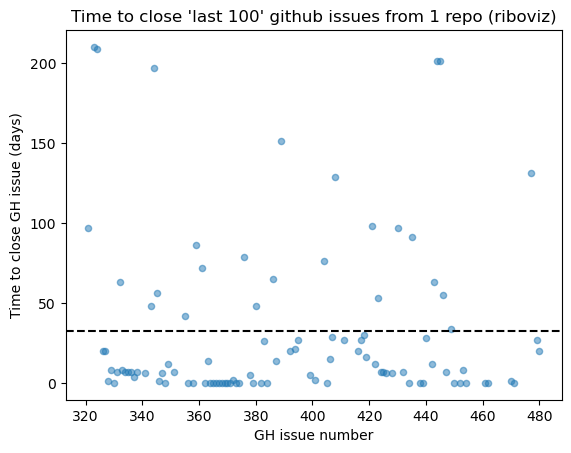

In [52]:
# plot  

closed_issue_df.plot.scatter(x='issue_number', y='close_time', alpha=0.5)
plt.xlabel("GH issue number")
plt.ylabel("Time to close GH issue (days)")
plt.title("Time to close 'last 100' github issues from 1 repo (riboviz)")
plt.axhline(y=np.mean(closed_issue_df.close_time), linestyle='--', color='black')  # add mean line with average close time for this set of issues
plt.show()


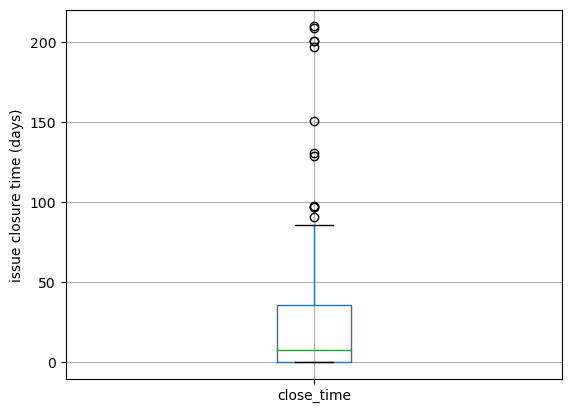

In [53]:
closed_issue_df.boxplot(column='close_time', grid=True) 
plt.ylabel("issue closure time (days)")# could use 'by=column' to groupby() eg. issue labels? 
plt.show()

ISSUE TICKETS TODO:   
 - PLOT times/dates of close time ALL issue tickets for this one repo.  
 - Plot issues with different colours per issue label types? (e.g. 'first issue' vs 'bug' vs other user defined labels?) 
 - Plot close times of assigned issues vs unassigned issues? 
 
 - adapt functions to take repo URL / LIST of repo URLS to be able to analyse more than one repo. 
 
 - create function which pulls data from github repo URL, calcs close times, plots repo issues (make optional) and returns dataframe for further analysis. 
  
 - write function which gets ALL issue ticket information from 1 repo into ONE df (e.g avoids PAGING issues from get_json_repo_issues(), pulls ALL creation/closure info etc, not just the title/ticket number as get_issues() does...)

 - address which issues are PRs (omit these from the issue tic calcs, they're generated separately)    
 - calc time to close PRs? Is this diff from issue timings?   
 
 - is it worth trying to sample amongst issue tickets to reduce run time? there's the DataFrame.sample() function that does this I think?  
 
 
 
 
DEFENSIVE PROGRAMMING TODO:    
 - all of it. :D  
  - Find whether a sample of ROpenSci R package repos on github use assertions?   
   - use of {testthat} package (but test for it as requirement, and then check if it's used and implemented AS INTENDED);   
   - avoidance of require() to import packages  
   - asserts present by some means    
   - message() / custom error messages used,   
   - stop(),   
   - tryCatch(),   
   - ... etc.   
 - Think about other parts of defensive programming I can look for - read more from below.    
 
 
 Reading:  
 [{testthat} R package info](https://testthat.r-lib.org/)
 [Hadley Wickham's Exceptions & Debugging advice from 'Advanced R'](http://adv-r.had.co.nz/Exceptions-Debugging.html)  
 [defensive programming in R](https://www.geeksforgeeks.org/defensive-programming-in-r/)
 [10 rules of defensive programming in R](https://www.r-bloggers.com/2018/07/the-ten-rules-of-defensive-programming-in-r/)